# Project overview

This project (1) models the evolution of various COVID-19-related measurements over time and (2) computes a simulation of the SIRV (Susceptible, Infected, Removed, Vaccinated) model, an epidemiological model that computes the theoretical number of people infected with a contagious illness in a closed population over time.

We build the SIRV model simulations for several countries in the context of the COVID-19 pandemic. By making assumptions on parameters, we can estimate different scenarios under which the pandemic could develop.

# Import of packages and loading of datasets

In this first section, we import the required modules and functions for the analysis. We then read the datasets stored inside a GitHub repository: https://github.com/titouanjd/ProgrammingForQA.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

plt.rcParams['figure.figsize'] = [12.0, 7.0] # change default size of plots (only working if the notebook is run twice)
plt.rcParams['axes.titlepad'] = 20 # change default distance of plot titles from plots

The analysis is based on five datasets:
- `vaccinations` contains information on the number of vaccinated individuals
- `confirmed`, `deaths` and `recovered` contain information on the number of people who have contracted, deceased, and recovered from COVID-19 respectively
- `population` contains population information for countries

In [43]:
folder = 'https://raw.githubusercontent.com/titouanjd/COVID_SIRV_model/main/data/'

vaccinations = pd.read_csv(folder + 'country_vaccinations.csv')
confirmed = pd.read_csv(folder + 'time_series_covid19_confirmed_global.csv')
deaths = pd.read_csv(folder + 'time_series_covid19_deaths_global.csv')
recovered = pd.read_csv(folder + 'time_series_covid19_recovered_global.csv')
population = pd.read_excel(folder + '_GM-Population-Dataset-v6.xlsx',
                           sheet_name='data-for-countries-etc-by-year',
                           usecols='B:D')

# Data Cleaning

Before running the analysis, data cleaning is required.

## Preliminary data cleaning

In this section, datasets are treated individually.

### `vaccinations` dataset

In [44]:
# visualise first 5 rows of the vaccinations dataset
vaccinations.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",World Health Organization,https://covid19.who.int/
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",World Health Organization,https://covid19.who.int/
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",World Health Organization,https://covid19.who.int/
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",World Health Organization,https://covid19.who.int/
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",World Health Organization,https://covid19.who.int/


In [45]:
# remove unecessary columns in vaccinations dataset
vaccinations = vaccinations.drop(['iso_code', 'daily_vaccinations_raw', 'vaccines', 'source_name', 'source_website'], axis='columns')

# replace 0 values with NaN values
vaccinations = vaccinations.replace(0, np.NaN)

# rename columns
vaccinations = vaccinations.rename(columns={'country': 'Country', 'date': 'Date'})

# set the right index
vaccinations = vaccinations.set_index('Country')

# visualise first 5 rows of the vaccinations dataset
vaccinations.head()

,Date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
Country,,,,,,,,,
Afghanistan,2021-02-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Afghanistan,2021-02-23,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0
Afghanistan,2021-02-24,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0
Afghanistan,2021-02-25,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0
Afghanistan,2021-02-26,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0


### `confirmed`, `deaths` and `recovered` datasets

> Since these three datasets come from the same source, they are built in the same way and data will therefore be cleaned similarly.

In [46]:
# visualise first 12 rows of confirmed dataset
confirmed.head(12)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/7/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,59576,59745,59939,60122,60300,60563,60797,61162,61455,61755,61842,62063,62403,62718,63045,63355,63412,63484,63598,63819,64122,64575,65080,65486,65728,66275,66903,67743,68366,69130,70111,70761,71838,72977,74026,75119,76628,77963,79224,80841
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,130977,131085,131185,131238,131276,131327,131419,131510,131577,131666,131723,131753,131803,131845,131890,131939,131978,132015,132032,132071,132095,132118,132153,132176,132209,132215,132229,132244,132264,132285,132297,132309,132315,132337,132351,132360,132372,132374,132379,132384
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,121866,122108,122311,122522,122717,122999,123272,123473,123692,123900,124104,124288,124483,124682,124889,125059,125194,125311,125485,125693,125896,126156,126434,126651,126860,127107,127361,127646,127926,128198,128456,128725,128913,129218,129640,129976,130361,130681,130958,131283
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,13198,13232,13232,13282,13295,13316,13340,13363,13390,13406,13423,13429,13447,13470,13470,13510,13510,13510,13555,13569,13569,13569,13569,13569,13569,13569,13664,13671,13682,13693,13693,13693,13727,13729,13744,13752,13758,13758,13758,13777
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,26431,26652,26815,26993,27133,27284,27529,27921,28201,28477,28740,28875,29146,29405,29695,30030,30354,30637,30787,31045,31438,31661,31909,32149,32441,32623,32933,33338,33607,33944,34180,34366,34551,34752,34960,35140,35307,35594,35772,35854
5,NaN,Antigua and Barbuda,17.06080,-61.796400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1231,1237,1238,1240,1240,1240,1241,1241,1251,1251,1252,1255,1255,1257,1257,1258,1258,1258,1258,1259,1259,1259,1260,1260,1262,1262,1263,1263,1263,1263
6,NaN,Argentina,-38.41610,-63.616700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2954943,2977363,2993865,3005259,3021179,3047417,3071496,3095582,3118134,3136158,3147740,3165121,3191097,3215572,3242103,3269466,3290935,3307285,3335965,3371508,3411160,3447044,3482512,3514683,3539484,3562135,3586736,3622135,3663215,3702422,3732263,3753609,3781784,3817139,3852156,3884447,3915397,3939024,3955439,3977634
7,NaN,Armenia,40.06910,45.038200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,215528,216064,216596,216863,217008,217407,217900,218325,218681,219092,219270,219353,219596,219950,220217,220447,220729,220860,220927,221139,221368,221559,221699,221880,221948,221982,222139,222269,222409,222513,222555,222636,222670,222778,222870,222978,223050,223143,223180,223212
8,Australian Capital Territory,Australia,-35.47350,149.012400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124
9,New South Wales,Australia,-33.86880,151.209300,0,0,0,0,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4

In [47]:
# rename Country/Region column to Country
confirmed = confirmed.rename(columns={'Country/Region': 'Country'})
deaths = deaths.rename(columns={'Country/Region': 'Country'})
recovered = recovered.rename(columns={'Country/Region': 'Country'})

# set the right index
confirmed = confirmed.set_index('Country')
deaths = deaths.set_index('Country')
recovered = recovered.set_index('Country')

# drop columns which will not be used
confirmed = confirmed.drop(['Province/State', 'Lat', 'Long'], axis='columns')
deaths = deaths.drop(['Province/State', 'Lat', 'Long'], axis='columns')
recovered = recovered.drop(['Province/State', 'Lat', 'Long'], axis='columns')

As seen above with the example of Australia (indexes 8 to 11), the `confirmed`, `deaths` and `recovered` datasets have several occurences of country names since some countries were previously divided among different provinces or states (in the `Province/State` column previously removed). Here we sum all values for each country and replace resulting zeros with `NaN` values.

In [48]:
# combine values for each country in the confirmed, deaths and recovered datasets
confirmed = confirmed.sum(level='Country')
deaths = deaths.sum(level='Country')
recovered = recovered.sum(level='Country')

# replace 0 values with NaN values
confirmed = confirmed.replace(0, np.NaN)
deaths = deaths.replace(0, np.NaN)
recovered = recovered.replace(0, np.NaN)

# visualise first 12 rows of the confirmed dataset (notice how the Australia rows have been combined into one)
confirmed.head(12)

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/7/21
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,59576.0,59745.0,59939.0,60122.0,60300.0,60563.0,60797.0,61162.0,61455.0,61755.0,61842.0,62063.0,62403.0,62718.0,63045.0,63355.0,63412.0,63484.0,63598.0,63819,64122,64575,65080,65486,65728,66275,66903,67743,68366,69130,70111,70761,71838,72977,74026,75119,76628,77963,79224,80841
Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,130977.0,131085.0,131185.0,131238.0,131276.0,131327.0,131419.0,131510.0,131577.0,131666.0,131723.0,131753.0,131803.0,131845.0,131890.0,131939.0,131978.0,132015.0,132032.0,132071,132095,132118,132153,132176,132209,132215,132229,132244,132264,132285,132297,132309,132315,132337,132351,132360,132372,132374,132379,132384
Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,...,121866.0,122108.0,122311.0,122522.0,122717.0,122999.0,123272.0,123473.0,123692.0,123900.0,124104.0,124288.0,124483.0,124682.0,124889.0,125059.0,125194.0,125311.0,125485.0,125693,125896,126156,126434,126651,126860,127107,127361,127646,127926,128198,128456,128725,128913,129218,129640,129976,130361,130681,130958,131283
Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13198.0,13232.0,13232.0,13282.0,13295.0,13316.0,13340.0,13363.0,13390.0,13406.0,13423.0,13429.0,13447.0,13470.0,13470.0,13510.0,13510.0,13510.0,13555.0,13569,13569,13569,13569,13569,13569,13569,13664,13671,13682,13693,13693,13693,13727,13729,13744,13752,13758,13758,13758,13777
Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26431.0,26652.0,26815.0,26993.0,27133.0,27284.0,27529.0,27921.0,28201.0,28477.0,28740.0,28875.0,29146.0,29405.0,29695.0,30030.0,30354.0,30637.0,30787.0,31045,31438,31661,31909,32149,32441,32623,32933,33338,33607,33944,34180,34366,34551,34752,34960,35140,35307,35594,35772,35854
Antigua and Barbuda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1232.0,1232.0,1232.0,1232.0,1232.0,1232.0,1232.0,1232.0,1232.0,1232.0,1231.0,1237.0,1238.0,1240.0,1240.0,1240.0,1241.0,1241.0,1251.0,1251,1252,1255,1255,1257,1257,1258,1258,1258,1258,1259,1259,1259,1260,1260,1262,1262,1263,1263,1263,1263
Argentina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2954943.0,2977363.0,2993865.0,3005259.0,3021179.0,3047417.0,3071496.0,3095582.0,3118134.0,3136158.0,3147740.0,3165121.0,3191097.0,3215572.0,3242103.0,3269466.0,3290935.0,3307285.0,3335965.0,3371508,3411160,3447044,3482512,3514683,3539484,3562135,3586736,3622135,3663215,3702422,3732263,3753609,3781784,3817139,3852156,3884447,3915397,3939024,3955439,3977634
Armen

We then transpose the dataframes and set a new date index called `Date` for later use.

In [49]:
# transpose dataframes
confirmed = confirmed.T
deaths = deaths.T
recovered = recovered.T

# set proper date index after converting its type from string
confirmed.index = pd.to_datetime(confirmed.index)
deaths.index = pd.to_datetime(deaths.index)
recovered.index = pd.to_datetime(recovered.index)

# rename indexes
confirmed.index.name = 'Date'
deaths.index.name = 'Date'
recovered.index.name = 'Date'

# visualise last 5 rows of the confirmed dataset
confirmed.tail()

Country,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Comoros,Congo (Brazzaville),...,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Solomon Islands,Somalia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tajikistan,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-03,75119.0,132360.0,129976.0,13752.0,35140.0,1262.0,3884447.0,222978.0,30141.0,645834.0,334416.0,11930.0,246658.0,805980.0,4026.0,396869.0,1066957.0,12840.0,8082.0,1654.0,380457.0,204252.0,56217.0,16803472.0,244.0,419180.0,13446.0,143945.0,4844.0,30774.0,32189.0,78929.0,1395336.0,7091.0,4935.0,1403101.0,103094.0,3488046.0,3882.0,11845.0,...,713207.0,11621.0,4162.0,62145.0,390129.0,254692.0,20.0,14699.0,1680373.0,10688.0,3693012.0,195844.0,35656.0,15676.0,1076993.0,696801.0,24591.0,9974.0,13308.0,509.0,169348.0,7422.0,13513.0,25272.0,350487.0,5270299.0,33326437.0,49759.0,2268209.0,576947.0,4515778.0,304411.0,100997.0,4.0,238013.0,8063.0,309333.0,6767.0,97388.0,39092.0
2021-06-04,76628.0,132372.0,130361.0,13758.0,35307.0,1263.0,3915397.0,223050.0,30157.0,646167.0,334539.0,11930.0,248150.0,807867.0,4029.0,398052.0,1068406.0,12861.0,8082.0,1669.0,383457.0,204304.0,56217.0,16841408.0,244.0,419337.0,13447.0,144157.0,4861.0,30907.0,33075.0,78929.0,1397370.0,7091.0,4938.0,1411346.0,103119.0,3518046.0,3886.0,11920.0,...,713417.0,12158.0,4168.0,62158.0,390223.0,254973.0,20.0,14699.0,1686041.0,10688.0,3697981.0,199254.0,35656.0,16009.0,1078062.0,697292.0,24619.0,10446.0,13308.0,509.0,171978.0,7511.0,13522.0,25801.0,352303.0,5276468.0,33343297.0,51006.0,2270602.0,579009.0,4521922.0,308490.0,101198.0,4.0,239252.0,8364.0,309644.0,6773.0,98376.0,39144.0
2021-06-05,77963.0,132374.0,130681.0,13758.0,35594.0,1263.0,3939024.0,223143.0,30173.0,646438.0,334647.0,11930.0,249582.0,809314.0,4030.0,398909.0,1069874.0,12861.0,8082.0,1682.0,385734.0,204304.0,56217.0,16907425.0,244.0,419426.0,13452.0,144253.0,4881.0,31003.0,33613.0,78929.0,1398719.0,7091.0,4939.0,1420266.0,103150.0,3547017.0,3886.0,11920.0,...,713562.0,12158.0,4188.0,62176.0,390340.0,255218.0,20.0,14729.0,1691491.0,10688.0,3697981.0,202357.0,35656.0,16292.0,1078062.0,697292.0,24639.0,10956.0,13308.0,509.0,174796.0,7659.0,13533.0,26192.0,353782.0,5282594.0,33357205.0,51676.0,2272633.0,581197.0,4527577.0,312703.0,101436.0,4.0,240714.0,8580.0,309853.0,6780.0,99540.0,39168.0
2021-06-06,79224.0,132379.0,130958.0,13758.0,35772.0,1263.0,3955439.0,223180.0,30191.0,646800.0,334715.0,11930.0,251078.0,810990.0,4031.0,399852.0,1070802.0,12861.0,8082.0,1687.0,387162.0,204304.0,56217.0,16947062.0,244.0,419473.0,13453.0,144317.0,4905.0,31097.0,34244.0,78929.0,1400093.0,7091.0,4939.0,1427956.0,103176.0,3571067.0,3888.0,11920.0,...,713678.0,12158.0,4201.0,62196.0,390436.0,255375.0,20.0,14748.0,1696564.0,10688.0,3697981.0,205333.0,35656.0,16541.0,1078062.0,697292.0,24659.0,11298.0,13308.0,509.0,177467.0,7740.0,13539.0,26410.0,355732.0,5287980.0,33362600.0,52935.0,2273708.0,583071.0,4532802.0,316535.0,101722.0,4.0,242138.0,8791.0,310026.0,6787.0,100278.0,39189.0
2021-06-07,80841.0,132384.0,131283.0,13777.0,35854.0,1263.0,3977634.0,223212.0,30205.0,647079.0,334747.0,12024.0,252600.0,812960.0,4032.0,400422.0,1071271.0,12899.0,8082.0,1703.0,387162.0,204410.0,58095.0,16984218.0,244.0,419681.0,13453.0,144456.0,4925.0,31147.0,34833.0,78929.0,1401912.0,7101.0,4940.0,1434884.0,103216.0,3593016.0,3890.0,12026.0,...,713840.0,12466.0,4208.0,62210.0

### `population` dataset

In [50]:
# visualise first 5 rows of population dataset
population.head()

,name,time,Population
0,Afghanistan,1800,3280000
1,Afghanistan,1801,3280000
2,Afghanistan,1802,3280000
3,Afghanistan,1803,3280000
4,Afghanistan,1804,3280000


In [51]:
# drop population data from past and future years in the population dataset
population = population.drop(population[population['time'] != 2021].index)

# drop time column since it is not needed anymore
population = population.drop('time', axis='columns')

# rename name column to Country
population = population.rename(columns={'name': 'Country'})

# set the right index
population = population.set_index('Country')

# visualise first 5 rows of population dataset
population.head()

,Population
Country,
Afghanistan,39835428
Albania,2872934
Algeria,44616626
Andorra,77354
Angola,33933611


## Matching datasets

In this section, we match country names of the four datasets (`vaccinations`, `confirmed`, `deaths`, `recovered`) before combining them into one entity based on `Date`.

### Matching indexes

Here, we match country names accross datasets.

> We consider that the three datasets `confirmed`, `deaths`, and `removed` contain the same country and therefore only use `confirmed` as a reference for the others.

In [52]:
# print country names that do not match the confirmed dataset
print('Countries in the vaccinations dataset that are not in the confirmed dataset:\n',
      [country for country in vaccinations.index.unique() if country not in confirmed.columns])
print('\nCountries in the population dataset that are not in the confirmed dataset:\n',
      [country for country in population.index if country not in confirmed.columns])

Countries in the vaccinations dataset that are not in the confirmed dataset:
 ['Anguilla', 'Aruba', 'Bermuda', 'Bonaire Sint Eustatius and Saba', 'British Virgin Islands', 'Cape Verde', 'Cayman Islands', 'Congo', 'Cook Islands', 'Curacao', 'Democratic Republic of Congo', 'England', 'Faeroe Islands', 'Falkland Islands', 'French Polynesia', 'Gibraltar', 'Greenland', 'Guernsey', 'Hong Kong', 'Isle of Man', 'Jersey', 'Macao', 'Montserrat', 'Myanmar', 'Nauru', 'New Caledonia', 'Northern Cyprus', 'Northern Ireland', 'Palestine', 'Pitcairn', 'Saint Helena', 'Scotland', 'Sint Maarten (Dutch part)', 'South Korea', 'Taiwan', 'Timor', 'Tonga', 'Turkmenistan', 'Turks and Caicos Islands', 'Tuvalu', 'United States', 'Wales', 'Wallis and Futuna']

Countries in the population dataset that are not in the confirmed dataset:
 ['Cape Verde', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Czech Republic', 'Hong Kong, China', 'North Korea', 'South Korea', 'Kyrgyz Republic', 'Lao', 'Macedonia, FYR', 'Micronesia, Fed. S

In [53]:
# looking for equivalents in the confirmed dataset
print('Countries in the confirmed dataset:\n', list(confirmed.columns))  # converted to list for consistency

Countries in the confirmed dataset:
 ['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'H

In [54]:
# replace some one country name in vaccinations and population datasets to match confirmed dataset
vaccinations = vaccinations.rename(index={'United States': 'US'})
population = population.rename(index={'United States': 'US'})

# drop England, Northern Ireland, Scotland and Wales from vaccinations since they are part of the United Kingdom
vaccinations = vaccinations.drop(['England', 'Northern Ireland', 'Scotland', 'Wales'], axis='index')

### Combining datasets

Firstly, we create a dictionary called `data` which stores country names as keys and corresponding `vaccinations` data as values.

Secondly, we merge the `confirmed`, `deaths` and `recovered` datasets to `data` for each country based on the `Date` index.

> For the remaining of the analysis, we will stop using the original `vaccinations`, `confirmed`, `deaths` and `recovered` datasets since they are all stored inside `data`.

In [55]:
# create empty dictionary
data = {}

# group vaccinations data by country
vaccinations_by_country = vaccinations.groupby('Country')

# loop over countries in the vaccinations dataset
for country in vaccinations.index.unique():
  # copy the relevant country rows to a temporary variable
  temp_data = vaccinations_by_country.get_group(country).copy()

  # convert date column from string type to Timestamp type
  temp_data.loc[:, 'Date'] = pd.to_datetime(temp_data.loc[:, 'Date'])

  # set proper index
  temp_data = temp_data.set_index('Date')

  # save dataframe with country name in the data dictionary
  data[country] = temp_data

  # try to merge the confirmed, deaths and recovered dataframes to vaccinations based on date and rename country to corresponding dataset
  try:
    data[country] = data[country].merge(confirmed[country], on='Date')
    data[country] = data[country].rename(columns={country: 'confirmed'})
    data[country] = data[country].merge(deaths[country], on='Date')
    data[country] = data[country].rename(columns={country: 'deaths'})
    data[country] = data[country].merge(recovered[country], on='Date')
    data[country] = data[country].rename(columns={country: 'recovered'})
  
  # if there is a KeyError (i.e., the country in vaccinations has no match in confirmed dataset, then delete it from the data dictionary)
  except KeyError:
    del data[country]

# visualise the names of the created data frames
data.keys()

dict_keys(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Laos

In [56]:
# visualise last 5 rows of the Switzerland dataframe inside the data dictionary
data['Switzerland'].tail()

,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,confirmed,deaths,recovered
Date,,,,,,,,,,,
2021-05-22,4244816.0,2752246.0,1492570.0,78666.0,49.05,31.80,17.25,9089.0,687353.0,10775.0,317600.0
2021-05-23,4273869.0,2772205.0,1501664.0,79458.0,49.38,32.03,17.35,9181.0,687353.0,10776.0,317600.0
2021-05-24,4322272.0,2802891.0,1519381.0,75032.0,49.94,32.39,17.56,8670.0,687353.0,10779.0,317600.0
2021-05-25,4414318.0,2851018.0,1563300.0,74811.0,51.01,32.94,18.06,8644.0,690123.0,10786.0,317600.0
2021-05-26,4521540.0,2906974.0,1614566.0,73937.0,52.24,33.59,18.66,8543.0,691119.0,10789.0,317600.0


# Plot data

In this section, we plot data to make sense of it. In the following two examples (plots 1 and 2), we use data solely from the newly-created `data` dictionary of dataframes.

## Plot 1: Evolution of the total number of vaccinations for 5 countries

Here, we plot the evolution of total number of vaccinations for 5 countries.

> Note that any other measurement and country could be ploted over time simply by changing the values of the variables `data_to_plot` and `countries_to_plot`.

In [57]:
print('Data available to plot:\n', list(data['Afghanistan'].columns))
print('\nCountries available to plot:\n', list(data.keys()))

Data available to plot:
 ['total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'daily_vaccinations', 'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 'daily_vaccinations_per_million', 'confirmed', 'deaths', 'recovered']

Countries available to plot:
 ['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 

In the following box of code, we can select which data and countries we would like to plot from the above lists and see the corresponding plot.

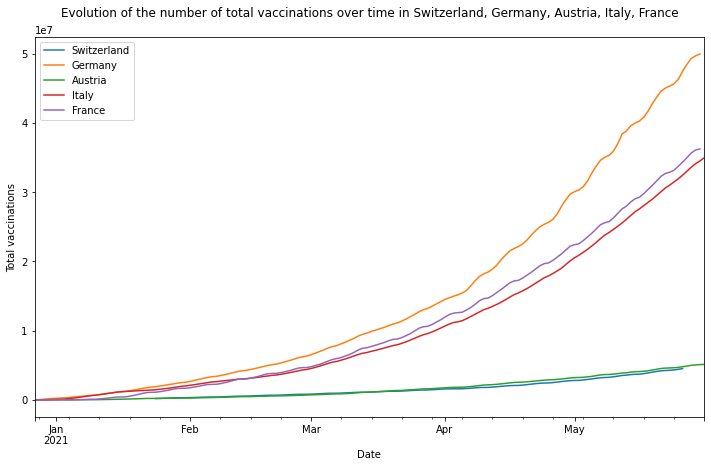

In [58]:
# select data and countries to plot
data_to_plot = 'total_vaccinations'
countries_to_plot = ['Switzerland', 'Germany', 'Austria', 'Italy', 'France']

# plot data
[data[country][data_to_plot].plot(label=country) for country in countries_to_plot]
plt.legend()
plt.title('Evolution of the number of ' + data_to_plot.replace('_', ' ') + ' over time in ' + (', ').join(countries_to_plot))
plt.ylabel(data_to_plot.replace('_', ' ').capitalize())
plt.show()

## Plot 2: Top 10 people fully vaccinated vs not fully vaccinated

Here is another graph example. It shows the top 10 countries with the highest number of people having received the first dose of the vaccine alongside the number of people who have also had the second dose.

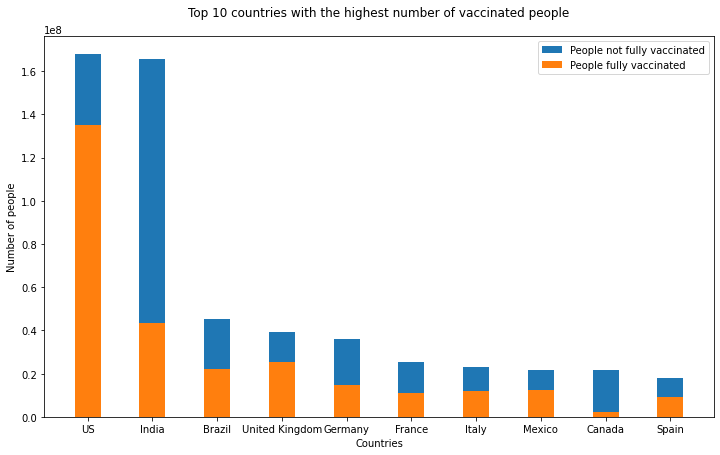

In [59]:
# series of the top 10 countries with the highest number of vaccinated people
people_vaccinated = pd.DataFrame()
for country in data:
  people_vaccinated[country] = data[country]['people_vaccinated']
people_vaccinated = people_vaccinated.iloc[-1].nlargest(10)

# list containing the values of the number of people fully vaccinated for the previous top 10 countries
people_fully_vaccinated = []
[people_fully_vaccinated.append(data[country]['people_fully_vaccinated'].max()) for country in people_vaccinated.index]

# plot data
x_label = people_vaccinated.index
width = 0.4
fig, ax = plt.subplots()
ax.bar(x=x_label, height=people_vaccinated, width=width, label='People not fully vaccinated')
ax.bar(x=x_label, height=people_fully_vaccinated, width=width, label='People fully vaccinated')
ax.set_xlabel('Countries')
ax.set_ylabel('Number of people')
ax.set_title('Top 10 countries with the highest number of vaccinated people')
ax.legend()
plt.show()

# SIRV Model

This final section aims at computing the SIRV Model.

To run the SIRV model, the population is divided in four states: Susceptible $S$, Infected $I$, Removed $R$ and Vaccinated $V$ (see below). The model can be used to predict the future transition of each of these states depending on the infection rate of the disease as well as the vaccination rate.

**Model parameters**
- $S$: Fraction of the population which is susceptible to have COVID-19 in the future
- $I$: Fraction of the population which is infected
- $R$: Fraction of the population which is removed (individuals who have either recovered or deceased from COVID-19)
- $V$: Fraction of the population which is vaccinated
- $\beta$: infection rate (number of contacts per infected person per day)
- $p$: Fraction of the population subject to a successful vaccination per day
- $p_g$: growth rate of $p$
- $\gamma$: rate of recovery (number of recoveries per person per day)

> Note that at any time: $S + I + R + V = 1$.

> $R_0 = \beta / \gamma$ is the basic repoduction number (average number of secondary infections caused by one infected individual during his/her entire infectious period).

**SIRV rates**
- Rate of change of $S$: $dS / dt = -\beta S I - p S$
- Rate of change of $I$: $dI / dt = \beta S I - \gamma I$
- Rate of change of $R$: $dR / dt = \gamma I$
- Rate of change of $V$: $dV / dt = p S$

**Model assumptions**
- No births
- No immigration
- Recovery gives total immunity
- There's a fixed daily infection rate $\beta$
- There's a fixed recovery time
- The vaccine is 100% effective instantly from the first dose
- $p$ will continue to grow at the same rate as it did in the past 30 days
- It takes exactly 14 days to recover from COVID-19

## The `SIRV` function

The model simulation is stored inside a function called `SIRV` for which the following parameters can be set.

**Function parameters**
- `S_today`: fraction of the population which is susceptible at time 0
- `I_today`: fraction of the population which is infected at time 0
- `R_today`: fraction of the population which is removed at time 0
- `V_today`: fraction of the population which is vaccinated at time 0
- `p`: fraction of the population subject to a successful vaccination per day
- `p_growth`: daily growth rate of `p` based on past historical growth rate
- `beta`: infection rate
- `ndays`: number of days for which we want to predict the model
- `dt`: time step in days
- `ndays_recovery`: no of days it takes to recover from COVID

> Note that a very high value of `beta` is used by default (`0.4`) to make the Infective proportion curve more interesting on the following graph. In practice, beta takes lower values.
- With $\beta = 0.4$ and $\gamma = 1 / 14$, $R_0 = \beta / \gamma = 0.4 * 14 = 5.6$
- Whereas in practice, $R_0$ typically fluctuates around $1$

> Also, note that the computation of a daily growth rate $p_{g, t}$ for $p$ is not present in the initial model. It is a personal addition that should make the model more accurate since in the context of the COVID-19, countries tend to increase their number of daily vaccinations over time. We calculate it on the basis of the daily growth over the past 30 days: $p_{g, t} = \sqrt[29]{v_0 / v_{-30}} - 1$ where $v_0$ is the number of daily vaccination today and $v_{-30}$ the number of daily vaccinations 30 days before.

In [60]:
def SIRV(S_today, I_today, R_today, V_today, p, p_growth, beta=0.4, ndays=180, dt=0.1, ndays_recovery=14):

  npts = int(ndays/dt) # number of data points to plot
  gamma = 1.0 / ndays_recovery # recovery rate

  # create arrays for storing S, I, R and t
  S = np.zeros(npts) # susceptible
  I = np.zeros(npts) # infective
  R = np.zeros(npts) # removed
  V = np.zeros(npts) # vaccinated
  t = np.arange(npts) * dt # number of days for which we want to predict the model

  # values at day 0
  S[0] = S_today
  I[0] = I_today
  R[0] = R_today
  V[0] = V_today

  # compute the expected values for the upcoming periods
  for i in range(npts - 1):
    # update the value of p with p_growth for each day
    if i % (1 / dt) == 0:
      p *= (1 + p_growth)
    
    # update S, I, R and V values
    S[i + 1] = S[i] - (beta * S[i] * I[i] + p * S[i]) * dt
    I[i + 1] = I[i] + (beta * S[i] * I[i] - gamma * I[i]) * dt
    R[i + 1] = R[i] + (gamma * I[i]) * dt
    V[i + 1] = V[i] + (p * S[i]) * dt # could also be written as: V[i + 1] = 1 - S[i+1] - I[i+1] - R[i+1]

  # calculate the basic reproduction number
  R_0 = beta / gamma

  return t, S, I, R, V, ndays, dt, R_0

The four states (`S`, `I`, `R`, and `V`) returned by the `SIRV` function can then be plotted over time for any country.

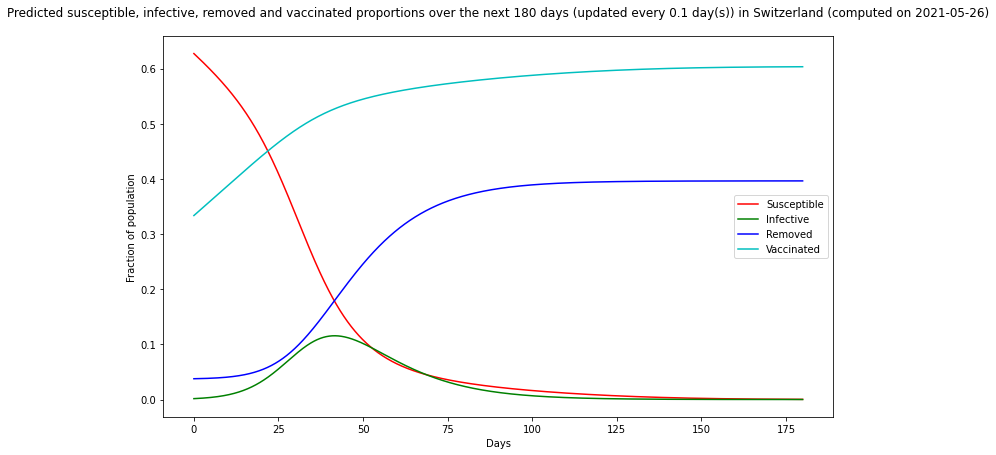

With the current parameters, since the basic reproduction number R_0 = 5.60 is greater than 1, the COVID infection will spread.
The maximum percentage of infected people at the same time will be of 11.56% in 42 days from now, that is 72.42 times more people than today.


In [61]:
# set country for which we want to plot the model
country_to_plot = 'Switzerland'

# attempt to run and plot the model for the country selected
try:
  # find last date which contains data for all columns
  date = -1
  while data[country_to_plot].iloc[date].isnull().any():
    date += 1

  # computation of the country's population, number of days required to revover from COVID-19 and current values of S, I, R, V
  pop = population.loc[country_to_plot][0] # country's population
  ndays_recovery = 14 # theoretical number of days required to recover from COVID-19
  I_today = (data[country_to_plot]['confirmed'][date] - data[country_to_plot]['confirmed'][date - ndays_recovery]) / pop # initial infective proportion
  R_today = (data[country_to_plot]['deaths'][date] + data[country_to_plot]['recovered'][date]) / pop # initial removed proportion
  V_today = data[country_to_plot]['people_vaccinated'][date] / pop # initial vaccinated proportion
  S_today = 1 - (I_today + R_today + V_today) # initial susceptible proportion

  # computation of the current value of p
  daily_vaccinations = data[country_to_plot]['daily_vaccinations']
  p = daily_vaccinations[date] / pop # initial daily fraction of the population subject to a successful vaccination

  # computation of the current value of p's growth rate
  date_min_30 = date - 30 # growth rate calculated on the basis of the daily vaccinations growth over the past 30 days
  p_growth = (daily_vaccinations[date] / daily_vaccinations[date_min_30]) ** (1 / (date - date_min_30 - 1)) - 1 # p's growth rate

  # compute function
  result = SIRV(S_today, I_today, R_today, V_today, p, p_growth, ndays_recovery=ndays_recovery)

  # plot data
  plt.plot(result[0], result[1], 'r', label='Susceptible')
  plt.plot(result[0], result[2], 'g', label='Infective')
  plt.plot(result[0], result[3], 'b', label='Removed')
  plt.plot(result[0], result[4], 'c', label='Vaccinated')
  plt.legend()
  plt.title(f'Predicted susceptible, infective, removed and vaccinated proportions over the next {result[5]} days (updated every {result[6]} day(s)) in {country_to_plot} (computed on {data[country_to_plot].index[date].date()})')
  plt.xlabel('Days')
  plt.ylabel('Fraction of population')
  plt.show()

  # computing sign of R_0 for printing
  if result[7] > 1:
    sign = 'greater than'
    spread = ''
  elif result[7] < 1:
    sign = 'smaller than'
    spread = 'not '
  else:
    sign = 'equal to'
    spread = ''

  # concluding sentences
  print(f'With the current parameters, since the basic reproduction number R_0 = {result[7]:.2f} is {sign} 1, the COVID infection will {spread}spread.')
  print(f'The maximum percentage of infected people at the same time will be of {result[2].max() * 100:.2f}% in {result[2].argmax() * result[6]:.0f} days from now, that is {result[2].max() / I_today:.2f} times more people than today.')

# fail if the country selected has some missing data (US for example)
except IndexError:
  print('Error:  Cannot compute the model, some data is missing for this country.')

# fail if the country selected is not available in this dataset
except KeyError:
  print('Error: Country not available in data.')

## SIRV model simulations for different values of $\beta$

In this section, we compute the evolution of the Infective proportion $I$ of the population over time for different values of $\beta$ in the `country_to_plot` selected above.

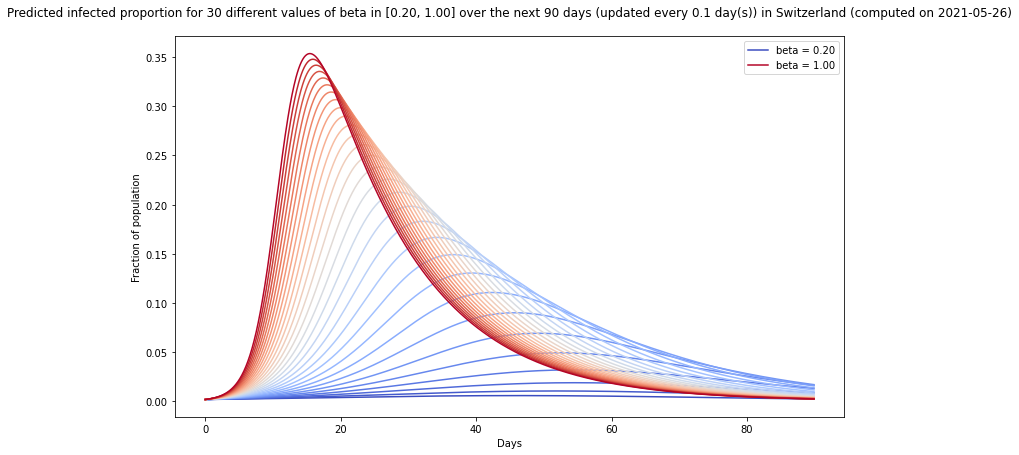

In [62]:
# set values of beta and number of days for which we want to test the SIRV model
beta_min = 0.2 # min value of beta
beta_max = 1 # max value of beta
num_to_plot = 30 # number of curves to compute
ndays = 90 # number of days for which we plot the function

# compute all values of beta
betas = np.linspace(beta_min, beta_max, num=num_to_plot)

# set plot colors
norm = colors.Normalize(vmin=betas.min(), vmax=betas.max())

# plot graph
for beta in betas:
  # Display label only for min and max values of beta
  if beta == betas.min() or beta == betas.max():
    mylabel = f'beta = {beta:.2f}'
  else:
    mylabel = None

  # compute function
  result = SIRV(S_today, I_today, R_today, V_today, p, p_growth, beta=beta, ndays=ndays, ndays_recovery=ndays_recovery)

  # plot data
  plt.plot(result[0], result[2], label=mylabel, color=plt.cm.coolwarm(norm(beta)))

plt.title(f'Predicted infected proportion for {num_to_plot} different values of beta in [{betas.min():.2f}, {betas.max():.2f}] over the next {result[5]} days (updated every {result[6]} day(s)) in {country_to_plot} (computed on {data[country_to_plot].index[date].date()})')
plt.xlabel('Days')
plt.ylabel('Fraction of population')
plt.legend()
plt.show()

# References

## Datasets

- `vaccinations`: https://www.kaggle.com/gpreda/covid-world-vaccination-progress
- `confirmed`, `deaths`, `recovered`: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series from https://ourworldindata.org/coronavirus#coronavirus-country-profiles
- `population`: https://ourworldindata.org/search?q=population

## SIRV Model

- Main $SIR$ explanation and code: https://youtube.com/playlist?list=PLN0b-Zk854ab_KQ_pa8YkAYK1FhuombtY
- "Vaccinated $V$" component of the model: http://hplgit.github.io/prog4comp/doc/pub/._p4c-solarized-Python021.html
- $R_0$ explanation: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1804098/